In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import math
import numpy as np
import torch as t
import torch.utils.data as tdata
import matplotlib.pyplot as plt
from einops import rearrange
from dots.training import *
from dots.trainhooks import *
from dots.models import MLP
from dots.dots import *
from dots.utils import get_device
from dots.plotting import *

In [2]:
import random
import time
from pathlib import Path
import pickle
import os
import copy
from collections import OrderedDict
import functools
import itertools
import gc

import numpy as np
import matplotlib.pyplot as plt
import einops
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import pandas as pd



In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
lr=1e-3 #@param
weight_decay = 0.1 #@param 
p=113 #@param
d_model = 128 #@param
fn_name = 'add' #@param ['add', 'subtract', 'x2xyy2','rand']
frac_train = 0.3 #@param
NUM_EPOCHS = 100000 #@param
save_models = False #@param
save_every = 1000 #@param
# Stop training when test loss is <stopping_thresh
stopping_thresh = -1 #@param
seed = 0 #@param
num_layers = 1
batch_style = 'full'
d_vocab = p+1 
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
#batch_size = BATCH_SIZE

In [5]:
def gen_train_test(frac_train = 0.3, num = 113, seed=0):
    # Generate train and test split
    pairs = [(i, j, num) for i in range(num) for j in range(num)]
    random.seed(seed)
    random.shuffle(pairs)
    div = int(frac_train*len(pairs))
    return pairs[:div], pairs[div:]

train_x, test_x = gen_train_test(frac_train, 113, seed=0)
print(len(train_x), len(test_x))

3830 8939


In [6]:
test_x[0]

(50, 67, 113)

In [7]:
def collate_batch(batch):
    label_list = [(i+j) % num for (i,j,num) in batch]
    label_list = torch.tensor(label_list, dtype=torch.int64)
    input_list = [torch.tensor(x) for x in batch]
    input_list = torch.cat(input_list).view(len(label_list), -1)
    return input_list.to(DEVICE), label_list.to(DEVICE)

# one batch per loader
train_loader = DataLoader(train_x, batch_size=len(train_x), collate_fn=collate_batch)
test_loader = DataLoader(test_x, batch_size=len(test_x), collate_fn=collate_batch)

print(len(train_loader))
for x, y in train_loader:
    print(x[:10])
    print(y[:10])

1
tensor([[ 18,  34, 113],
        [ 10,  83, 113],
        [ 55,  28, 113],
        [ 25,  51, 113],
        [ 63,  65, 113],
        [ 14, 104, 113],
        [ 27,  56, 113],
        [ 35,  77, 113],
        [ 41,  72, 113],
        [ 17, 111, 113]], device='cuda:0')
tensor([ 52,  93,  83,  76,  15,   5,  83, 112,   0,  15], device='cuda:0')


In [8]:
batch = next(iter(train_loader))
batch_x = batch[0]
batch_y = batch[1]

In [9]:
batch_x.shape

torch.Size([3830, 3])

In [10]:
batch_x[0]

tensor([ 18,  34, 113], device='cuda:0')

In [11]:
train_x = next(iter(train_loader))[0]
test_x = next(iter(test_loader))[0]

In [12]:
print(train_x.shape)
print(test_x.shape)

torch.Size([3830, 3])
torch.Size([8939, 3])


# Load models

In [13]:
mnames = [
    f"grok_{prepend_zeros(i * 1000, 5)}"
    for i in range(0, 100)
]
models = [
    load_model(name) for name in mnames
]

# Best Jacobian method?

In [57]:
s = 64
model = models[0]

In [58]:
jac = model.matrix_jacobian(test_x[:s])
jac.shape

torch.Size([7296, 226816])

In [59]:
t.linalg.matrix_rank(jac)

tensor(1739, device='cuda:0')

The below was with jac calculated when s = 128, and the fact that it's less than the above line is suspicious as hell:

In [56]:
t.linalg.matrix_rank(jac @ jac.T)

tensor(753, device='cuda:0')

In [43]:
U, S, V = model.jacobian_svd(test_x[:s])

/home/lrl34/.conda/envs/dots/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


In [46]:
U.shape

torch.Size([7296, 7296])

In [47]:
S.shape

torch.Size([7296])

In [49]:
V.shape

torch.Size([7296, 226816])

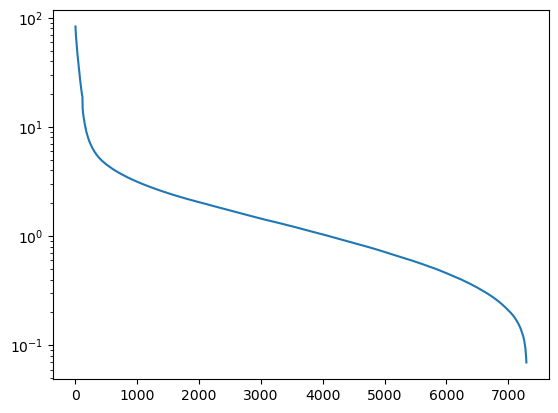

In [52]:
plt.plot(S.cpu())
plt.yscale("log")

TENTATIVE CONCLUSION: use 64 elements for calculating ranks

# Calculating ranks using a small number of test/train elements

## Test

In [15]:
from tqdm.notebook import tqdm

In [16]:
ranks = []

for model in tqdm(models):
    ranks.append(
        model.jacobian_matrix_rank(test_x[:64])
    ) 

  0%|          | 0/100 [00:00<?, ?it/s]

/home/lrl34/.conda/envs/dots/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


In [24]:
t.save([rank.item() for rank in ranks], "grok_ranks_test64.pt")

In [27]:
t.load("grok_ranks_test64.pt")

[1739,
 4417,
 4540,
 4682,
 4835,
 4985,
 5124,
 5244,
 5315,
 5379,
 5421,
 5452,
 5478,
 5486,
 5483,
 5474,
 5471,
 5463,
 5453,
 5427,
 5399,
 5372,
 5340,
 5318,
 5304,
 5286,
 5265,
 5246,
 5223,
 5198,
 5167,
 5135,
 5126,
 5101,
 5079,
 5071,
 5045,
 5007,
 4980,
 4950,
 4908,
 4865,
 4846,
 4781,
 4724,
 4660,
 4610,
 4538,
 4487,
 4421,
 4353,
 4254,
 4154,
 4056,
 3946,
 3839,
 3678,
 3510,
 3348,
 3149,
 2929,
 2708,
 2443,
 2261,
 2127,
 2032,
 1944,
 1888,
 1821,
 1766,
 1724,
 1707,
 1671,
 1640,
 1613,
 1602,
 1594,
 1579,
 1573,
 1558,
 1535,
 1526,
 1558,
 1545,
 1537,
 1528,
 1518,
 1512,
 1505,
 1500,
 1472,
 1423,
 1405,
 1392,
 1384,
 1377,
 1377,
 1376,
 1374,
 1372]

## Train

In [14]:
train_ranks = []

for model in tqdm(models):
    train_ranks.append(
        model.jacobian_matrix_rank(train_x[:64]).item()
    ) 

  0%|          | 0/100 [00:00<?, ?it/s]

/home/lrl34/.conda/envs/dots/lib/python3.10/site-packages/torch/nn/utils/stateless.py:216: UserWarning: This API is deprecated as of PyTorch 2.0 and will be removed in a future version of PyTorch. Please use torch.func.functional_call instead which is a drop-in replacement for this API.
  warnings.warn(


In [15]:
t.save(train_ranks, "grok_ranks_train64.pt")

In [16]:
t.load("grok_ranks_train64.pt")

[1748,
 4590,
 4756,
 4883,
 5043,
 5172,
 5288,
 5385,
 5460,
 5510,
 5536,
 5550,
 5568,
 5562,
 5540,
 5527,
 5497,
 5476,
 5455,
 5438,
 5422,
 5401,
 5392,
 5371,
 5344,
 5320,
 5286,
 5270,
 5236,
 5221,
 5196,
 5178,
 5149,
 5108,
 5075,
 5054,
 5020,
 5007,
 4969,
 4930,
 4878,
 4856,
 4825,
 4774,
 4716,
 4678,
 4608,
 4543,
 4455,
 4380,
 4291,
 4190,
 4083,
 3942,
 3800,
 3635,
 3448,
 3301,
 3121,
 2927,
 2746,
 2530,
 2322,
 2149,
 2021,
 1920,
 1880,
 1842,
 1800,
 1780,
 1753,
 1723,
 1724,
 1718,
 1695,
 1671,
 1644,
 1626,
 1607,
 1595,
 1577,
 1562,
 1552,
 1541,
 1535,
 1528,
 1521,
 1514,
 1506,
 1504,
 1498,
 1443,
 1415,
 1401,
 1391,
 1385,
 1380,
 1377,
 1375,
 1373]